# Analysis of US Covid

In [108]:
import pandas as pd
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import math

## Load and combine data
### Load Covid testing data from Covid Tracking

In [187]:
statecovid = pd.read_csv('https://covidtracking.com/api/v1/states/current.csv')

Remove fields we are not interested in.  Keep fields are:
- state
- positive - Total cumulative positive test results.
- negative - Total cumulative negative test results.
- score - Total reporting quality score.
- totalTestResults - Calculated value (positive + negative) of total test results.
- hospitalized - Total cumulative number of people hospitalized.
- death - Total cumulative number of people that have died.

In [191]:
statecovid = statecovid[["state", "positive", "negative", "score", "totalTestResults", "death"]].copy()

### Add state GDP data from bea.gov to COVID data

In [193]:
gdp = pd.read_csv("gdp.csv")

In [194]:
statecovid = statecovid.join(gdp.set_index('State'), on='state').copy()

### Get state abbreviations

In [197]:
abbrv = pd.read_csv('name-abbr.csv', header=None)

In [198]:
abbrv.columns = ["name", "abbrv"]

### Add estimated 2019 state population data from census.gov to COVID data

In [199]:
pop = pd.read_csv('nst-est2019-alldata.csv')

Fix DC capitalization issue.

In [200]:
pop.iloc[13,4] = 'District Of Columbia'

Transform the population data
- Remove unneeded fields
- Join to abbreviation data to get state abbreviation instead of name
- Remove non state records

In [201]:
pop = pop[["NAME", "POPESTIMATE2019"]].join(abbrv.set_index('name'), on='NAME')[["abbrv", "POPESTIMATE2019"]].dropna().copy()

Add population data to COVID data

In [202]:
statecovid = statecovid.join(pop.set_index('abbrv'), on='state').copy()

### Add state area data from statesymbolsusa.org to COVID data

In [210]:
area = pd.read_csv('statearea.csv')

In [212]:
area.columns = ['State', 'Area']

Get state abbreviation

In [213]:
area = area.join(abbrv.set_index('name'), on='State')[["abbrv", "Area"]].copy()

In [207]:
statecovid = statecovid.join(area.set_index('abbrv'), on='state').copy()

Missing area of DC, get from wikipedia and fix

In [218]:
statecovid.iloc[7, 8] = 68.34

### Get historical data from COVID Tracking to get date of first test and date of first case

In [220]:
statehist = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

In [221]:
statehist["date"] = pd.to_datetime(statehist["date"], format='%Y%m%d')

In [222]:
statefirstcase = statehist[statehist["positive"] > 0][["date", "state"]].groupby(['state']).min().reset_index().copy()

In [223]:
statefirstcase.rename(columns = {'date':"dateOfFirstCase"}, inplace = True)

In [224]:
statefirstcase["daysSinceFirstCase"] = (pd.to_datetime(date.today()) - statefirstcase["dateOfFirstCase"]).astype('timedelta64[D]')

In [225]:
statecovid = statecovid.join(statefirstcase[["state", "dateOfFirstCase","daysSinceFirstCase"]].set_index('state'), on='state').copy()

In [226]:
statefirsttest = statehist[statehist["negative"] > 0][["date", "state"]].groupby(['state']).min().reset_index().copy()

In [227]:
statefirsttest.rename(columns = {'date':"dateOfFirstTest"}, inplace = 1)

In [228]:
statefirsttest["daysSinceFirstTest"] = (pd.to_datetime(date.today()) - statefirsttest["dateOfFirstTest"]).astype('timedelta64[D]')

In [229]:
statecovid = statecovid.join(statefirsttest[["state", "dateOfFirstTest", "daysSinceFirstTest"]].set_index('state'), on='state').copy()

### Get State School Closure Data
Data source is https://www.edweek.org/ew/section/multimedia/map-coronavirus-and-school-closures.html

In [231]:
stateschool = pd.read_csv('StateSchool.csv', header=1)

In [232]:
stateschool = stateschool[["State Abbreviation", "State Status", "State Closure Start Date"]].copy()

In [233]:
stateschool["State Closure Start Date"] = pd.to_datetime(stateschool["State Closure Start Date"], format='%m/%d/%Y')

In [234]:
statecovid = statecovid.join(stateschool.set_index('State Abbreviation'), on='state').copy()

In [235]:
statecovid["daysFromFirstCaseUntilSchoolsClosed"] = (statecovid["State Closure Start Date"] - statecovid["dateOfFirstCase"]).astype('timedelta64[D]')

### Calcualte population density and percent of tests that where positive

In [237]:
statecovid = statecovid.dropna().copy()

In [239]:
statecovid["popdensity"] = statecovid["POPESTIMATE2019"]/statecovid["Area"]

In [240]:
statecovid["postivePercent"] = statecovid["positive"]/statecovid["totalTestResults"]

In [252]:
statecovid["gdpPerArea"] = statecovid[" GDP"]/statecovid["Area"]

### View Dataset

In [253]:
statecovid

,state,positive,negative,score,totalTestResults,death,GDP,POPESTIMATE2019,Area,dateOfFirstCase,daysSinceFirstCase,dateOfFirstTest,daysSinceFirstTest,State Status,State Closure Start Date,daysFromFirstCaseUntilSchoolsClosed,popdensity,postivePercent,gdpPerArea
0,AK,277,7553,4.0,7830,8.0,55759.0,731545.0,570641.00,2020-03-13,32.0,2020-03-06,39.0,State ordered closure,2020-03-16,3.0,1.281971,0.035377,0.097713
1,AL,3734,25448,3.0,29182,99.0,234054.0,4903185.0,50750.00,2020-03-13,32.0,2020-03-11,34.0,State ordered closure,2020-03-19,6.0,96.614483,0.127956,4.611901
2,AR,1410,19394,4.0,20804,30.0,135225.0,3017804.0,52075.00,2020-03-12,33.0,2020-03-06,39.0,State ordered closure,2020-03-17,5.0,57.951109,0.067775,2.596735
3,AZ,3702,39645,3.0,43347,122.0,372522.0,7278717.0,113642.00,2020-03-04,41.0,2020-03-04,41.0,State ordered closure,2020-03-16,12.0,64.049533,0.085404,3.278031
4,CA,22348,168534,3.0,190882,687.0,3183251.0,39512223.0,155973.00,2020-03-04,41.0,2020-03-04,41.0,State recommended closure,2020-03-19,15.0,253.327326,0.117078,20.408987
5,CO,7684,29850,4.0,37534,304.0,396367.0,5758736.0,103730.00,2020-03-06,39.0,2020-03-05,40.0,State ordered closure,2020-03-23,17.0,55.516591,0.204721,3.821141
6,CT,13381,30928,4.0,44309,602.0,288985.0,3565287.0,4845.00,2020-03-08,37.0,2020-03-08,37.0,State ordered closure,2020-03-17,9.0,735.869350,0.301993,59.646027
7,DC,1955,8979,4.0,10934,53.0,148231.0,705749.0,68.34,2020-03-08,37.0,2020-03-05,40.0,State ordered closure,2020-03-16,8.0,10327.026632,0.178800,2169.022534
8,DE,1625,10195,4.0,11820,35.0,76410.0,973764.0,1955.00,2020-03-11,34.0,2020-03-06,39.0,State ordered closure,2020-03-16,5.0,498.089003,0.137479,39.084399
9,FL,20601,175606,4.0,196207,483.0,1111378.0,21477737.0,53997.00,2020-03-04,41.0,2020-03-04,41.0,State recommended closure,2020-03-16,12.0,397.757968,0.104996,20.582218


## Find the best model

### Analyze Correlation

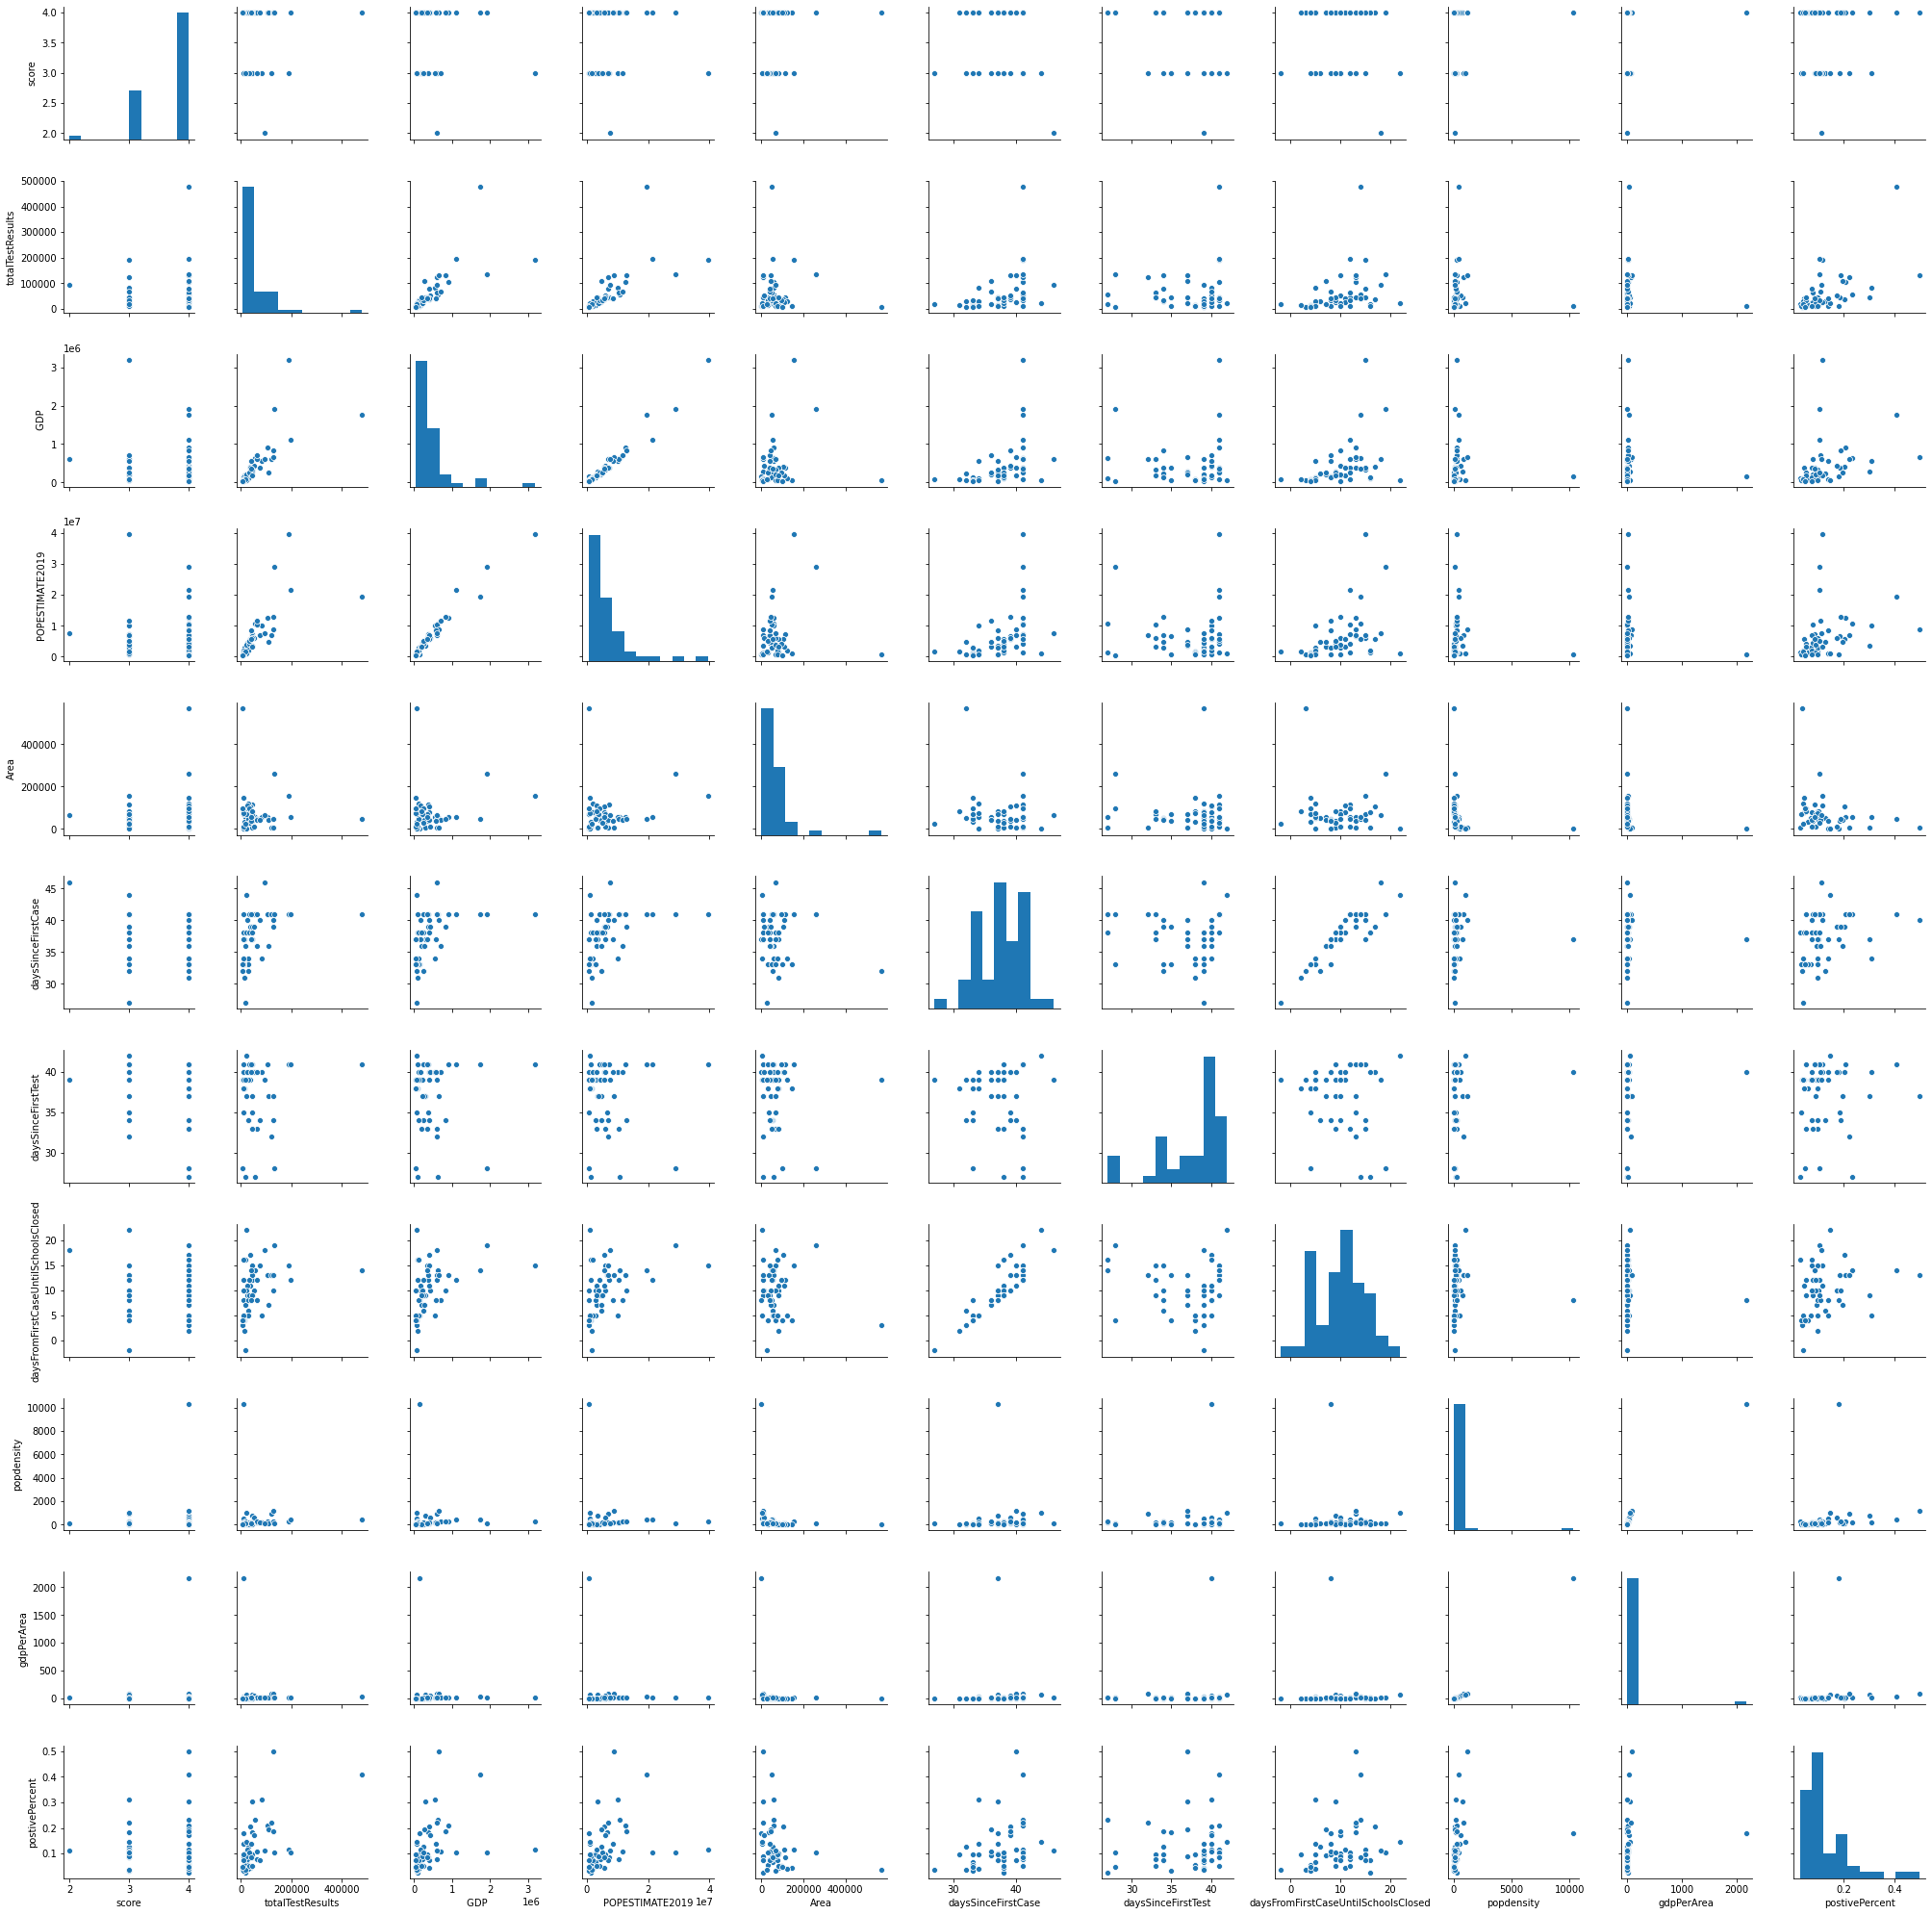

In [255]:
sns.pairplot(statecovid[["score", "totalTestResults", " GDP", "POPESTIMATE2019", "Area", "daysSinceFirstCase", "daysSinceFirstTest", "daysFromFirstCaseUntilSchoolsClosed", "popdensity", "gdpPerArea", "postivePercent"]])

In [256]:
statecovid[["score", "totalTestResults", " GDP", "POPESTIMATE2019", "Area", "daysSinceFirstCase", "daysSinceFirstTest", "daysFromFirstCaseUntilSchoolsClosed", "popdensity", "gdpPerArea", "postivePercent"]].corr(method='pearson')

,score,totalTestResults,GDP,POPESTIMATE2019,Area,daysSinceFirstCase,daysSinceFirstTest,daysFromFirstCaseUntilSchoolsClosed,popdensity,gdpPerArea,postivePercent
score,1.000000,0.013172,-0.098886,-0.086603,0.105998,-0.157060,-0.168377,-0.102900,0.073792,0.083928,0.021320
totalTestResults,0.013172,1.000000,0.737546,0.698468,-0.026239,0.398906,0.062354,0.332307,-0.027432,-0.063784,0.577916
GDP,-0.098886,0.737546,1.000000,0.978942,0.151545,0.432881,0.006619,0.416610,-0.033747,-0.056304,0.328240
POPESTIMATE2019,-0.086603,0.698468,0.978942,1.000000,0.155264,0.434431,-0.027262,0.417151,-0.079017,-0.099859,0.287054
Area,0.105998,-0.026239,0.151545,0.155264,1.000000,-0.152525,-0.032316,-0.109839,-0.176429,-0.136701,-0.263780
daysSinceFirstCase,-0.157060,0.398906,0.432881,0.434431,-0.152525,1.000000,0.067995,0.889816,0.051277,0.006115,0.286802
daysSinceFirstTest,-0.168377,0.062354,0.006619,-0.027262,-0.032316,0.067995,1.000000,-0.084149,0.102562,0.096795,0.065366
daysFromFirstCaseUntilSchoolsClosed,-0.102900,0.332307,0.416610,0.417151,-0.109839,0.889816,-0.084149,1.000000,0.003815,-0.038727,0.236356
popdensity,0.073792,-0.027432,-0.033747,-0.079017,-0.176429,0.051277,0.102562,0.003815,1.000000,0.992966,0.199308
gdpPerArea,0.083928,-0.063784,-0.056304,-0.099859,-0.136701,0.006115,0.096795,-0.038727,0.992966,1.000000,0.124789


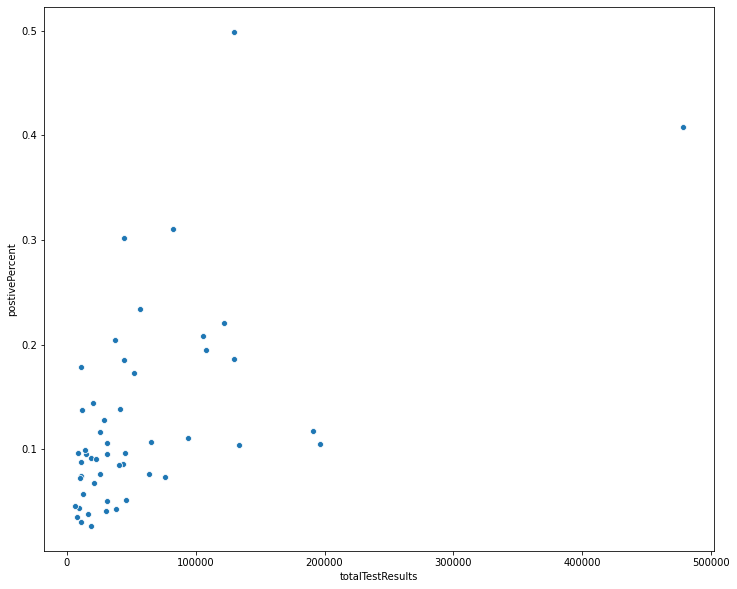

In [244]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x="totalTestResults", y="postivePercent", data=statecovid)

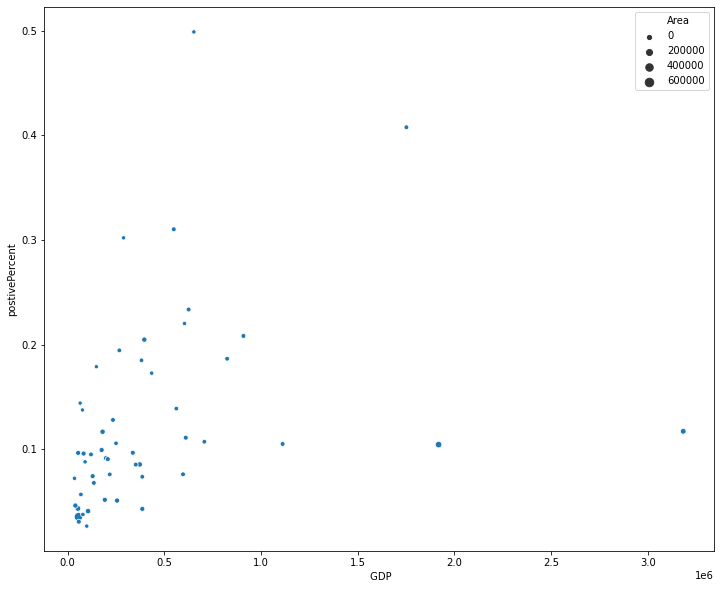

In [251]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=" GDP", y="postivePercent", size='Area', data=statecovid)

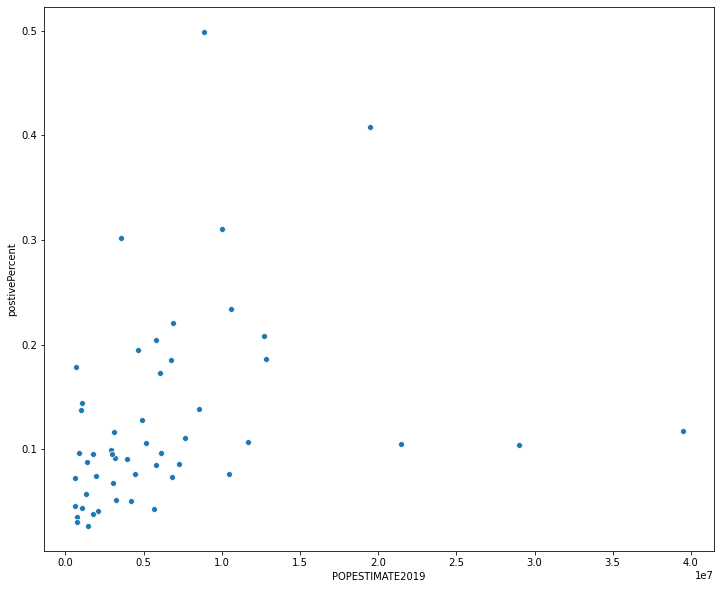

In [246]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x="POPESTIMATE2019", y="postivePercent", data=statecovid)

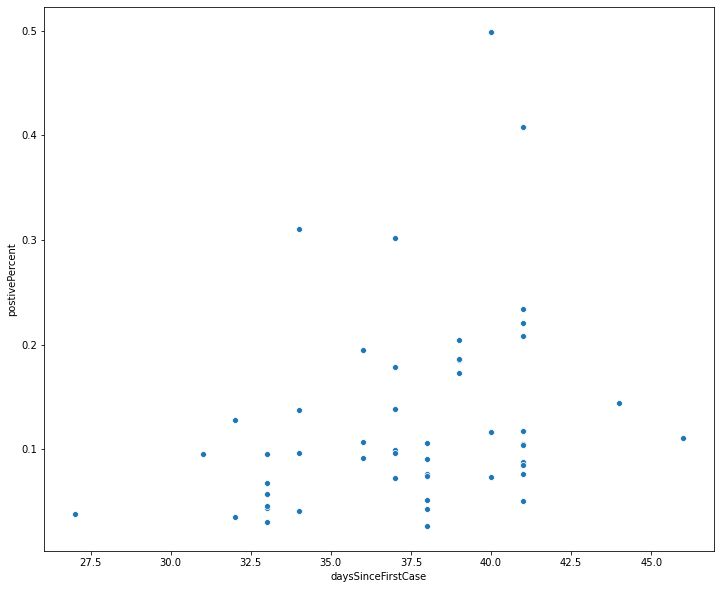

In [247]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x="daysSinceFirstCase", y="postivePercent", data=statecovid)

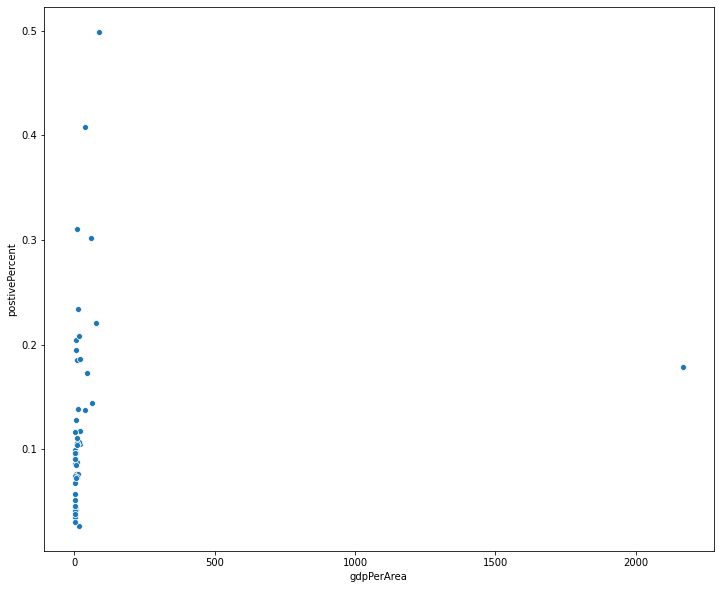

In [257]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x="gdpPerArea", y="postivePercent", data=statecovid)

GDP by area seems like it could have pretty good correlation, however DC is an extreme outlier and is throwing the data off
Since DC is not a typical state, I am going to exclude it from the dataset

In [278]:
statecovid = statecovid[statecovid["state"] != 'DC'].copy()

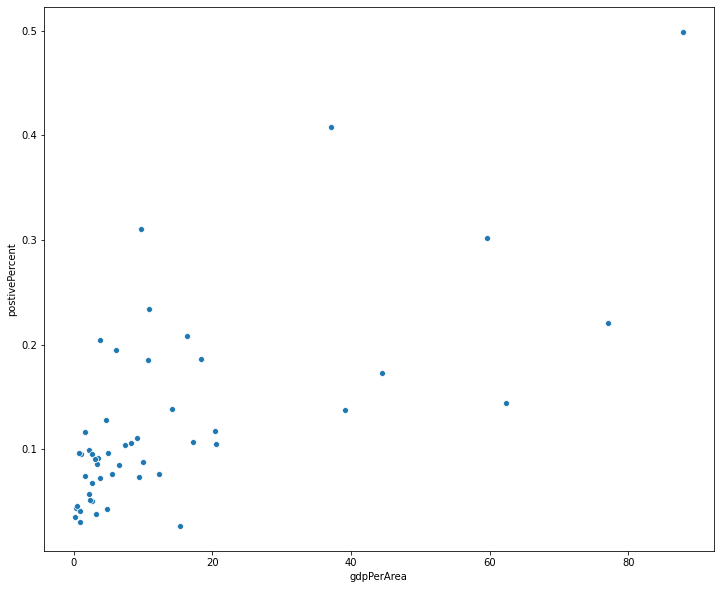

In [279]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x="gdpPerArea", y="postivePercent", data=statecovid)

In [280]:
statecovid[["score", "totalTestResults", " GDP", "POPESTIMATE2019", "Area", "daysSinceFirstCase", "daysSinceFirstTest", "daysFromFirstCaseUntilSchoolsClosed", "popdensity", "gdpPerArea", "postivePercent"]].corr(method='pearson')

,score,totalTestResults,GDP,POPESTIMATE2019,Area,daysSinceFirstCase,daysSinceFirstTest,daysFromFirstCaseUntilSchoolsClosed,popdensity,gdpPerArea,postivePercent
score,1.000000,0.021040,-0.093242,-0.077605,0.117408,-0.156155,-0.178281,-0.098212,-0.069994,-0.058470,0.014420
totalTestResults,0.021040,1.000000,0.736007,0.695699,-0.036760,0.398974,0.071324,0.328932,0.324087,0.361478,0.589022
GDP,-0.093242,0.736007,1.000000,0.979580,0.144671,0.432800,0.013493,0.414159,0.198528,0.221297,0.335800
POPESTIMATE2019,-0.077605,0.695699,0.979580,1.000000,0.144260,0.435257,-0.016820,0.413821,0.167708,0.169942,0.298702
Area,0.117408,-0.036760,0.144671,0.144260,1.000000,-0.155609,-0.021510,-0.117730,-0.347009,-0.326403,-0.257108
daysSinceFirstCase,-0.156155,0.398974,0.432800,0.435257,-0.155609,1.000000,0.069991,0.890495,0.376145,0.357958,0.289152
daysSinceFirstTest,-0.178281,0.071324,0.013493,-0.016820,-0.021510,0.069991,1.000000,-0.078956,0.047648,0.022535,0.058210
daysFromFirstCaseUntilSchoolsClosed,-0.098212,0.328932,0.414159,0.413821,-0.117730,0.890495,-0.078956,1.000000,0.343762,0.316460,0.242301
popdensity,-0.069994,0.324087,0.198528,0.167708,-0.347009,0.376145,0.047648,0.343762,1.000000,0.985496,0.667321
gdpPerArea,-0.058470,0.361478,0.221297,0.169942,-0.326403,0.357958,0.022535,0.316460,0.985496,1.000000,0.692426


### Find model candidates

In [281]:
def regVarTestSM(DF, excludeCols, responseVar, numReturnedRecs):
    cols = DF.drop(excludeCols, axis=1).columns
    rows_list = []

    varcombos = []
    for i in np.arange(1, len(DF.drop(excludeCols, axis=1))+1):
        for c in list(itertools.combinations(DF.drop(excludeCols, axis=1), i)):
            varcombos.append(list(c))

    for c in varcombos:
        model = sm.OLS(DF[responseVar], DF[c])
        res = model.fit()
        dict1 = {}
        dict1['Vars'] = len(c)
        for col in cols:
            dict1[col] ='X' if (col in c) else ''
        dict1['AIC'] = res.aic
        rows_list.append(dict1)
    
    return pd.DataFrame(rows_list).groupby(["Vars"]).apply(lambda x : x.sort_values(["AIC"])).reset_index(drop=True).groupby('Vars').head(numReturnedRecs)

In [331]:
regVarTestSM(statecovid[["score", "totalTestResults", " GDP", "POPESTIMATE2019", "Area", "daysSinceFirstCase", "daysSinceFirstTest", "daysFromFirstCaseUntilSchoolsClosed", "popdensity", "gdpPerArea", "postivePercent"]], ['postivePercent'], 'postivePercent', 4)

,Vars,score,totalTestResults,GDP,POPESTIMATE2019,Area,daysSinceFirstCase,daysSinceFirstTest,daysFromFirstCaseUntilSchoolsClosed,popdensity,gdpPerArea,AIC
0,1,,,,,,X,,,,,-95.807007
1,1,,,,,,,,,X,,-93.838382
2,1,,,,,,,X,,,,-92.610931
3,1,,,,,,,,,,X,-92.284943
10,2,,,,,,X,,,,X,-123.469873
11,2,,,,,,,X,,,X,-123.379999
12,2,X,,,,,,,,,X,-123.341116
13,2,X,,,,,,,,X,,-120.342126
55,3,X,X,,,,,,,,X,-135.900673
56,3,,X,,,,,X,,,X,-135.758364


### Evaluate best models
#### Look at first model candidate
View model summary

In [310]:
X = statecovid[["gdpPerArea", "totalTestResults", "score"]]
y = pd.to_numeric(statecovid["postivePercent"])
olsmod = sm.OLS(y, X)

In [312]:
olsres = olsmod.fit()

In [313]:
print(olsres.summary())

                                 OLS Regression Results                                
Dep. Variable:         postivePercent   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                              96.30
Date:                Tue, 14 Apr 2020   Prob (F-statistic):                    4.38e-20
Time:                        01:33:25   Log-Likelihood:                          70.950
No. Observations:                  50   AIC:                                     -135.9
Df Residuals:                      47   BIC:                                     -130.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

-------------------------------------------------------

Evaluate model for conditions of regression inference

In [317]:
predicts = olsres.predict(statecovid[["gdpPerArea", "totalTestResults", "score"]])

In [318]:
res = statecovid["postivePercent"].to_numpy() - predicts

- Do the residuals follow a normal distribution?
    
    not great, but acceptable

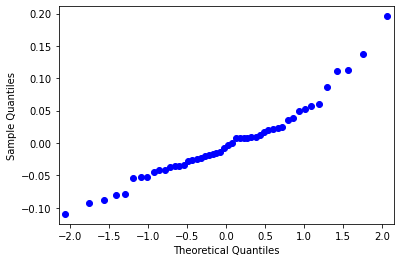

In [319]:
fig = sm.qqplot(res)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3dc270edd8>]],
      dtype=object)

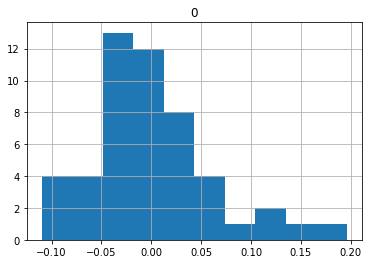

In [320]:
pd.DataFrame(res).hist()

- The errors are uncorrelated

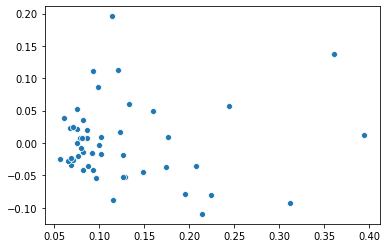

In [321]:
sns.scatterplot(x=predicts, y=res)

- Constant error variance

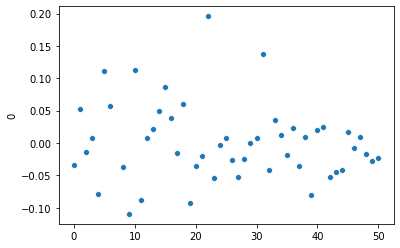

In [322]:
resdf = pd.DataFrame(res)
sns.scatterplot(x=resdf.index, y=resdf[0])

----------------------------
Lets look at residual values by state

In [301]:
stateres = statecovid[["state", "postivePercent"]].copy()

In [325]:
stateres["predict"] = predicts

In [326]:
stateres["res"] = res

In [327]:
stateres

,state,postivePercent,predict,res
0,AK,0.035377,0.068921,-0.033545
1,AL,0.127956,0.075011,0.052944
2,AR,0.067775,0.081829,-0.014054
3,AZ,0.085404,0.078334,0.007069
4,CA,0.117078,0.195195,-0.078118
5,CO,0.204721,0.093177,0.111544
6,CT,0.301993,0.244454,0.057539
8,DE,0.137479,0.174210,-0.036732
9,FL,0.104996,0.214451,-0.109455
10,GA,0.233510,0.121106,0.112404


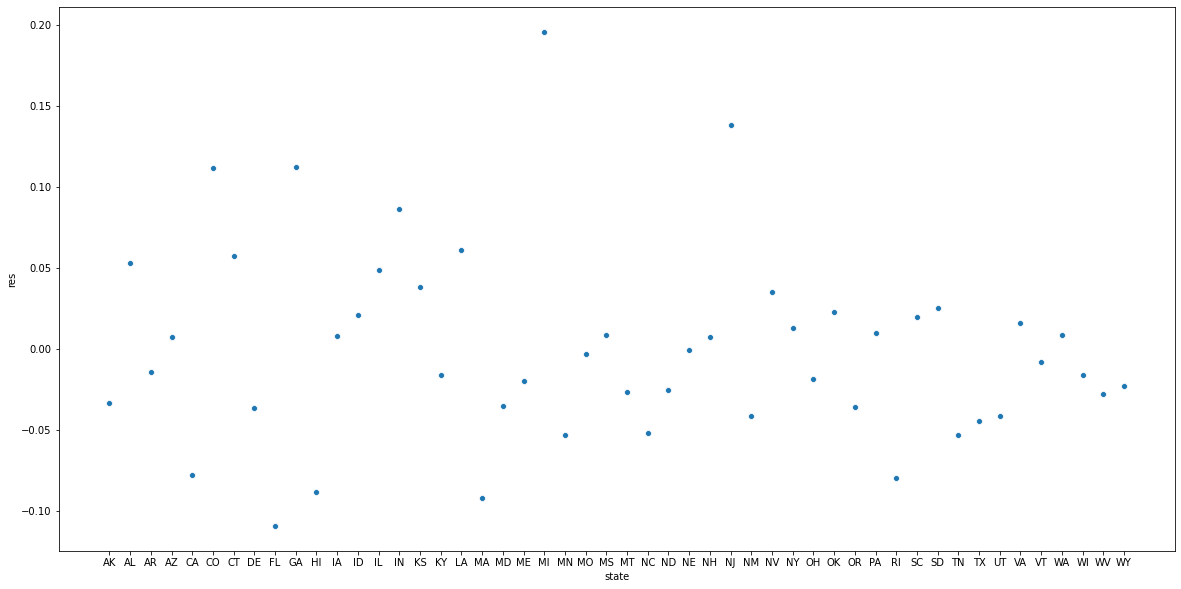

In [328]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="state", y="res", data=stateres)

In [329]:
stateres.describe()

,postivePercent,predict,res
count,50.000000,50.000000,50.000000
mean,0.125293,0.124664,0.000630
std,0.094754,0.075110,0.059137
min,0.026481,0.056079,-0.109455
25%,0.072526,0.078751,-0.035834
50%,0.096508,0.094784,-0.005539
75%,0.142733,0.132104,0.022366
max,0.498838,0.394856,0.195790




## Conclusion
GDP per area, the total test results, and the data quality score are the best predictors of the percent of positive test results

If all other variables are held constant, for every 1 million/mile squared increase in GDP per area it is estimated the positive test percentage goes up by 0.0027.

If all other variables are held constant, for every 1 additional test conducted it is estimated the positive test percentage goes up by 0.0000004843.

If all other variables are held constant, for every 1 points increase in data quality score, it is estimated the positive test percentage goes up by 0.0162.